In [25]:
# ============================================================
# Block #1: Imports
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["figure.dpi"] = 120

In [26]:
# ============================================================
# Block #2: Trapezoidal integrator for C x' + G x = b(t)
# ============================================================

def trapezoidal_mna(C, G, b_func, t_grid, x0):
    """
    Solve C x'(t) + G x(t) = b(t) using the trapezoidal rule.
    
    Parameters
    ----------
    C : (n, n) ndarray
        "Capacitance / inductance" matrix from MNA (C matrix).
    G : (n, n) ndarray
        Conductance / static matrix from MNA (G matrix).
    b_func : callable
        b_func(t) -> (n,) array, right-hand side (sources).
    t_grid : (N,) ndarray
        Time points where solution is computed (uniform step).
    x0 : (n,) ndarray
        Initial state x(t_0).
    
    Returns
    -------
    X : (N, n) ndarray
        Solution at each time step.
    Bvals : (N, n) ndarray
        b(t) evaluated at each time step (for debugging / tables).
    """
    t_grid = np.asarray(t_grid)
    dt = t_grid[1] - t_grid[0]
    n = C.shape[0]
    N = len(t_grid)

    X = np.zeros((N, n))
    Bvals = np.zeros((N, n))
    X[0] = x0

    # Precompute constant matrices
    C_dt = C / dt
    A_lhs = C_dt + 0.5 * G
    A_lhs_inv = np.linalg.inv(A_lhs)

    # Time stepping
    for k in range(N - 1):
        t_k = t_grid[k]
        t_k1 = t_grid[k + 1]

        b_k = np.asarray(b_func(t_k))
        b_k1 = np.asarray(b_func(t_k1))
        Bvals[k] = b_k

        rhs = (C_dt - 0.5 * G) @ X[k] + 0.5 * (b_k + b_k1)
        X[k + 1] = A_lhs_inv @ rhs

    Bvals[-1] = np.asarray(b_func(t_grid[-1]))
    return X, Bvals


In [27]:
# ============================================================
# Block #3: Dynamic phasor over sliding window
# ============================================================

def compute_dynamic_phasor(signal, t_grid, f0, periods_in_window=1):
    """
    Compute dynamic phasor X̃(t) of a real-valued signal x(t).
    
    Dynamic phasor of order k=1 (fundamental):
        X̃(t) ≈ (1/T) ∫_{t-T}^{t} x(τ) e^{-j 2π f0 τ} dτ
    
    Here we approximate with a sliding discrete window.
    
    Parameters
    ----------
    signal : (N,) ndarray
        Real-valued time-domain signal samples.
    t_grid : (N,) ndarray
        Sampling times (uniform step).
    f0 : float
        Fundamental frequency [Hz] used for the phasor.
    periods_in_window : int
        Number of fundamental periods in the integration window.
    
    Returns
    -------
    X_dyn : (N,) ndarray of complex
        Dynamic phasor at each time step (NaN for first samples
        where the window is not full).
    """
    t_grid = np.asarray(t_grid)
    x = np.asarray(signal)
    dt = t_grid[1] - t_grid[0]

    T0 = 1.0 / f0
    window_length = int(round(periods_in_window * T0 / dt))
    if window_length < 2:
        raise ValueError("Window too short compared to dt.")

    N = len(t_grid)
    X_dyn = np.full(N, np.nan, dtype=complex)

    omega0 = 2 * np.pi * f0

    for k in range(window_length - 1, N):
        idx_start = k - window_length + 1
        idx_end = k + 1

        t_win = t_grid[idx_start:idx_end]
        x_win = x[idx_start:idx_end]

        # Exponential kernel e^{-j ω0 t}
        kernel = np.exp(-1j * omega0 * t_win)
        integral_approx = np.sum(x_win * kernel) * dt
        T_window = (t_win[-1] - t_win[0])

        X_dyn[k] = (1.0 / T_window) * integral_approx

    return X_dyn


# Report 1

$$
\underbrace{\begin{bmatrix}
L & 0 \\
0 & C
\end{bmatrix}}_{C}
\begin{bmatrix}
\dot i_L \\
\dot v_C
\end{bmatrix}
+
\underbrace{\begin{bmatrix}
R & 1 \\
-1 & 0
\end{bmatrix}}_{G}
\begin{bmatrix}
i_L \\
v_C
\end{bmatrix}
=
\begin{bmatrix}
v_s(t) \\
0
\end{bmatrix}
$$


In [28]:
# ============================================================
# Block #4: Parameters for Report 1 (linear RLC)
# ============================================================

# Circuit parameters
R = 10.0      # Ohm
L = 10e-3     # H
Cval = 100e-6 # F

# Source: slowly amplitude-modulated sinusoid
f0 = 50.0     # fundamental frequency [Hz]
omega0 = 2 * np.pi * f0
Vm = 10.0     # base amplitude [V]

def v_source_linear(t):
    # Simple amplitude step (to make dynamic phasor slightly time-varying)
    # t < 0.05s: amplitude = 5 V, t >= 0.05s: amplitude = 10 V
    amp = 5.0 if t < 0.05 else 10.0
    return amp * np.sin(omega0 * t)

# MNA matrices C and G
C_mat = np.array([[L, 0.0],
                  [0.0, Cval]], dtype=float)

G_mat = np.array([[R, 1.0],
                  [-1.0, 0.0]], dtype=float)

def b_linear(t):
    return np.array([v_source_linear(t), 0.0])

# Time grid
t_end = 0.2    # 200 ms
dt = 1e-5      # 10 microseconds
t = np.arange(0.0, t_end + dt, dt)

# Initial conditions (zero current/voltage)
x0 = np.array([0.0, 0.0])

# Run simulation
X_lin, B_lin = trapezoidal_mna(C_mat, G_mat, b_linear, t, x0)

# Extract signals
i_L_lin = X_lin[:, 0]
v_C_lin = X_lin[:, 1]
v_s_lin = B_lin[:, 0]


In [29]:
# ============================================================
# Block #5: Dynamic phasor for Report 1
# ============================================================

# Use 1 fundamental period for the window
X_i_dyn_lin = compute_dynamic_phasor(i_L_lin, t, f0, periods_in_window=1)
X_v_dyn_lin = compute_dynamic_phasor(v_C_lin, t, f0, periods_in_window=1)

# Magnitude and phase (in degrees)
I_mag_lin = np.abs(X_i_dyn_lin)
I_phase_lin = np.rad2deg(np.angle(X_i_dyn_lin))

V_mag_lin = np.abs(X_v_dyn_lin)
V_phase_lin = np.rad2deg(np.angle(X_v_dyn_lin))


In [30]:
# ============================================================
# Block #6: Table for Report 1 (head of results)
# ============================================================

# Downsample for table readability (e.g. every 100th point)
stride = 100
df_lin = pd.DataFrame({
    "t [s]": t[::stride],
    "i_L(t) [A]": i_L_lin[::stride],
    "v_C(t) [V]": v_C_lin[::stride],
    "|Î_dyn(t)| [A]": I_mag_lin[::stride],
    "∠Î_dyn(t) [deg]": I_phase_lin[::stride],
    "|Ṽ_dyn(t)| [V]": V_mag_lin[::stride],
    "∠Ṽ_dyn(t) [deg]": V_phase_lin[::stride],
})

df_lin.head()


,t [s],i_L(t) [A],v_C(t) [V],|Î_dyn(t)| [A],∠Î_dyn(t) [deg],|Ṽ_dyn(t)| [V],∠Ṽ_dyn(t) [deg]
0,0.000,0.000000,0.000000,NaN,NaN,NaN,NaN
1,0.001,0.052936,0.197147,NaN,NaN,NaN,NaN
2,0.002,0.127025,1.120667,NaN,NaN,NaN,NaN
3,0.003,0.152221,2.566913,NaN,NaN,NaN,NaN
4,0.004,0.124176,3.984594,NaN,NaN,NaN,NaN


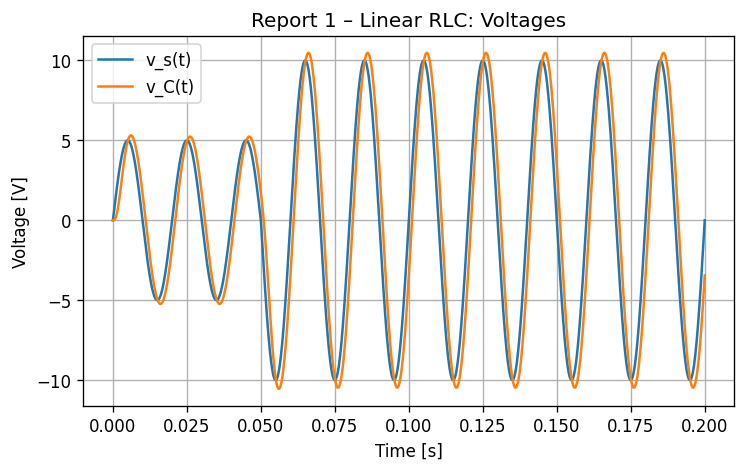

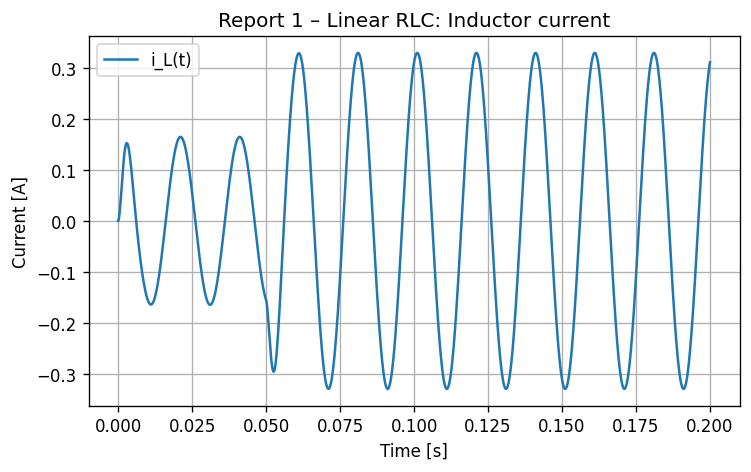

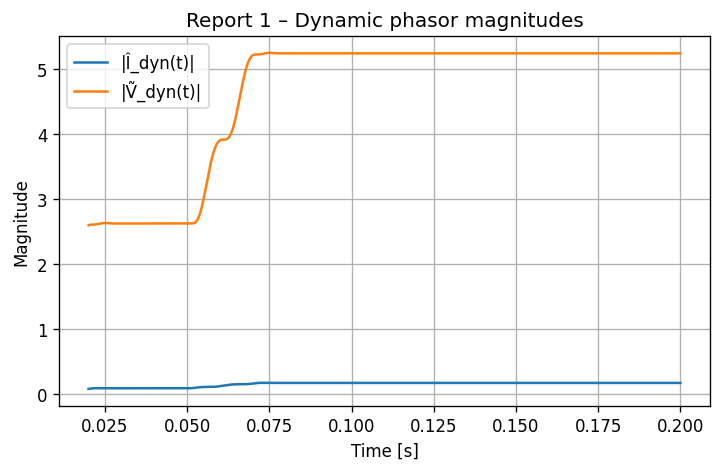

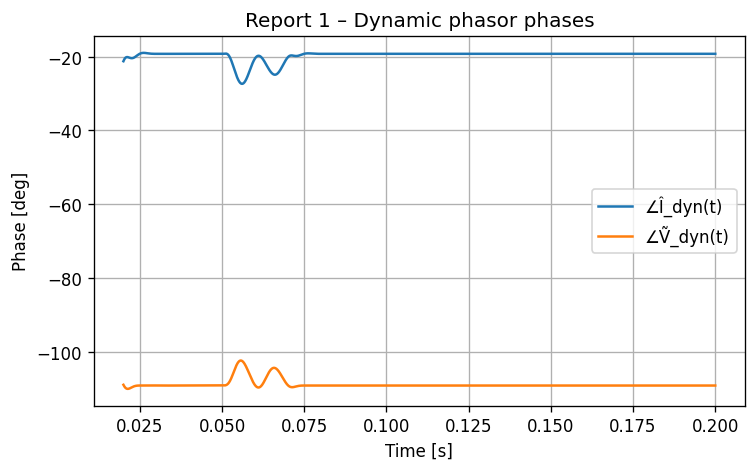

In [31]:
# ============================================================
# Block #7: Plots for Report 1
# ============================================================

# Time-domain waveforms
fig, ax = plt.subplots()
ax.plot(t, v_s_lin, label="v_s(t)")
ax.plot(t, v_C_lin, label="v_C(t)")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Voltage [V]")
ax.set_title("Report 1 – Linear RLC: Voltages")
ax.legend()
ax.grid(True)
plt.show()

fig, ax = plt.subplots()
ax.plot(t, i_L_lin, label="i_L(t)")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Current [A]")
ax.set_title("Report 1 – Linear RLC: Inductor current")
ax.legend()
ax.grid(True)
plt.show()

# Dynamic phasor magnitude (ignore initial NaNs)
valid = ~np.isnan(I_mag_lin)

fig, ax = plt.subplots()
ax.plot(t[valid], I_mag_lin[valid], label="|Î_dyn(t)|")
ax.plot(t[valid], V_mag_lin[valid], label="|Ṽ_dyn(t)|")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Magnitude")
ax.set_title("Report 1 – Dynamic phasor magnitudes")
ax.legend()
ax.grid(True)
plt.show()

fig, ax = plt.subplots()
ax.plot(t[valid], I_phase_lin[valid], label="∠Î_dyn(t)")
ax.plot(t[valid], V_phase_lin[valid], label="∠Ṽ_dyn(t)")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Phase [deg]")
ax.set_title("Report 1 – Dynamic phasor phases")
ax.legend()
ax.grid(True)
plt.show()


# Report 2

Source:

$$
v_s^{(sw)}(t)=s(t)V_m\sin(2\pi f_0 t)


In [32]:
# ============================================================
# Block #8: Parameters for Report 2 (switching RLC)
# ============================================================

# Reuse same R, L, Cval, f0, omega0
Vm_sw = 10.0       # amplitude of sinusoidal carrier
f_sw = 1000.0      # switching frequency [Hz]
duty = 0.5         # 50% duty cycle

def pwm_switch(t, f_sw=f_sw, duty=duty):
    """
    Simple PWM switch: returns 1 (ON) or 0 (OFF).
    """
    T_sw = 1.0 / f_sw
    tau = t % T_sw
    return 1.0 if tau < duty * T_sw else 0.0

def v_source_switched(t):
    s = pwm_switch(t)
    return s * Vm_sw * np.sin(omega0 * t)

def b_switched(t):
    return np.array([v_source_switched(t), 0.0])

# Time grid (same as before, but you can change if needed)
t_end2 = 0.05   # 50 ms -> several switching periods
dt2 = 1e-6      # small time step because of high f_sw
t2 = np.arange(0.0, t_end2 + dt2, dt2)

x0_2 = np.array([0.0, 0.0])

# Run simulation
X_sw, B_sw = trapezoidal_mna(C_mat, G_mat, b_switched, t2, x0_2)

i_L_sw = X_sw[:, 0]
v_C_sw = X_sw[:, 1]
v_s_sw = B_sw[:, 0]


In [33]:
# ============================================================
# Block #9: Dynamic phasor for switching case
# ============================================================

X_i_dyn_sw = compute_dynamic_phasor(i_L_sw, t2, f0, periods_in_window=1)
X_v_dyn_sw = compute_dynamic_phasor(v_C_sw, t2, f0, periods_in_window=1)

I_mag_sw = np.abs(X_i_dyn_sw)
I_phase_sw = np.rad2deg(np.angle(X_i_dyn_sw))

V_mag_sw = np.abs(X_v_dyn_sw)
V_phase_sw = np.rad2deg(np.angle(X_v_dyn_sw))


In [34]:
# ============================================================
# Block #10: Table for Report 2 (head of results)
# ============================================================

stride2 = 200  # heavier downsample because dt is very small
df_sw = pd.DataFrame({
    "t [s]": t2[::stride2],
    "i_L(t) [A]": i_L_sw[::stride2],
    "v_C(t) [V]": v_C_sw[::stride2],
    "|Î_dyn(t)| [A]": I_mag_sw[::stride2],
    "∠Î_dyn(t) [deg]": I_phase_sw[::stride2],
    "|Ṽ_dyn(t)| [V]": V_mag_sw[::stride2],
    "∠Ṽ_dyn(t) [deg]": V_phase_sw[::stride2],
})

df_sw.head()


,t [s],i_L(t) [A],v_C(t) [V],|Î_dyn(t)| [A],∠Î_dyn(t) [deg],|Ṽ_dyn(t)| [V],∠Ṽ_dyn(t) [deg]
0,0.0000,0.000000,0.000000,NaN,NaN,NaN,NaN
1,0.0002,0.005863,0.003979,NaN,NaN,NaN,NaN
2,0.0004,0.021776,0.030152,NaN,NaN,NaN,NaN
3,0.0006,0.028846,0.087999,NaN,NaN,NaN,NaN
4,0.0008,0.021528,0.138296,NaN,NaN,NaN,NaN


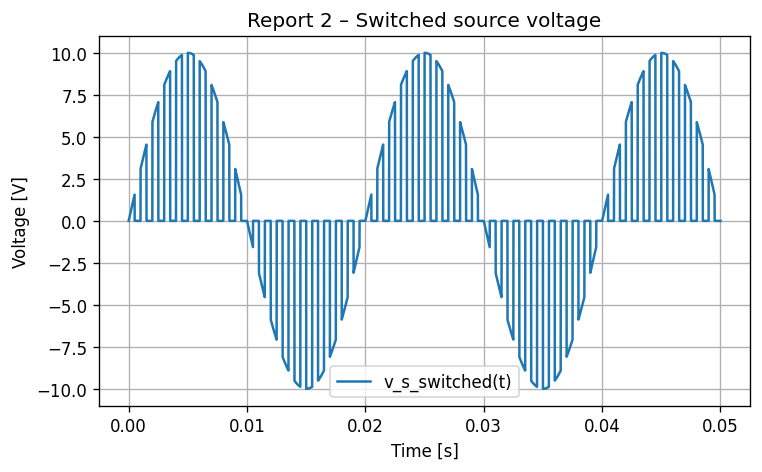

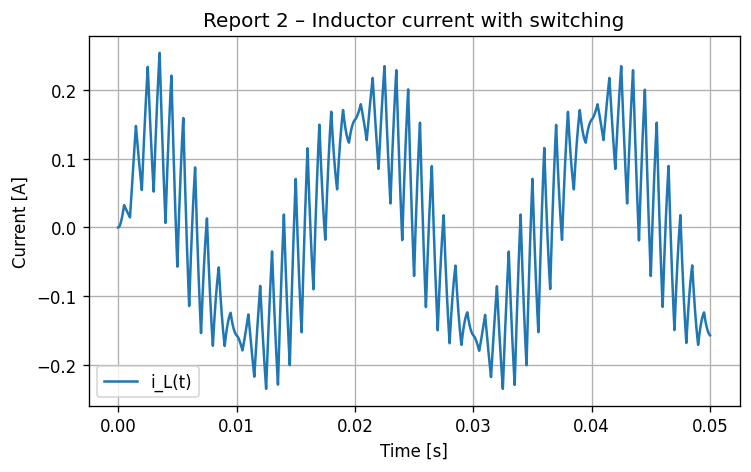

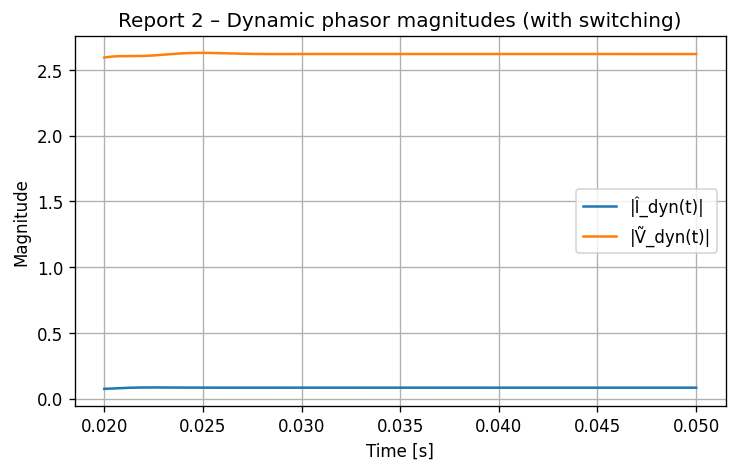

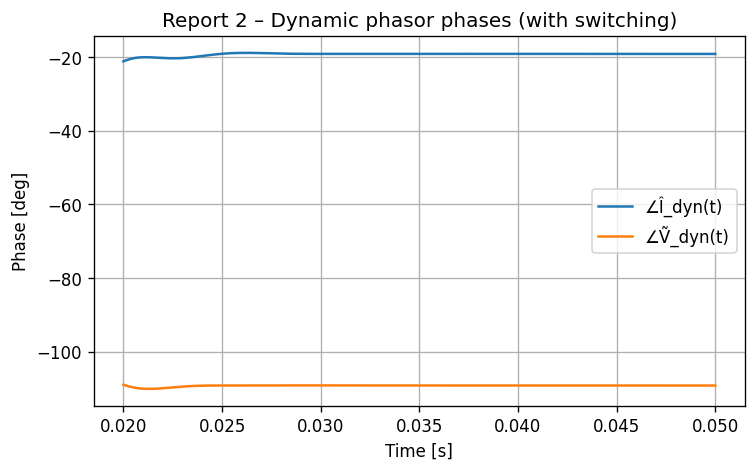

In [35]:
# ============================================================
# Block #11: Plots for Report 2
# ============================================================

# Time-domain waveforms (zoom in to see switching)
fig, ax = plt.subplots()
ax.plot(t2, v_s_sw, label="v_s_switched(t)")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Voltage [V]")
ax.set_title("Report 2 – Switched source voltage")
ax.legend()
ax.grid(True)
plt.show()

fig, ax = plt.subplots()
ax.plot(t2, i_L_sw, label="i_L(t)")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Current [A]")
ax.set_title("Report 2 – Inductor current with switching")
ax.legend()
ax.grid(True)
plt.show()

# Dynamic phasor magnitudes (ignore initial NaNs)
valid2 = ~np.isnan(I_mag_sw)

fig, ax = plt.subplots()
ax.plot(t2[valid2], I_mag_sw[valid2], label="|Î_dyn(t)|")
ax.plot(t2[valid2], V_mag_sw[valid2], label="|Ṽ_dyn(t)|")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Magnitude")
ax.set_title("Report 2 – Dynamic phasor magnitudes (with switching)")
ax.legend()
ax.grid(True)
plt.show()

fig, ax = plt.subplots()
ax.plot(t2[valid2], I_phase_sw[valid2], label="∠Î_dyn(t)")
ax.plot(t2[valid2], V_phase_sw[valid2], label="∠Ṽ_dyn(t)")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Phase [deg]")
ax.set_title("Report 2 – Dynamic phasor phases (with switching)")
ax.legend()
ax.grid(True)
plt.show()


# Test Limitation of Dynamic Phasors in RLC circuit

- Frequency: 50Hz (20ms)
- Amplitude $A_n$: choose one random value from {0V, 5V, 10V}
- Duty Ratio $D#: Random value between 0.1 and 0.9

within the preiod, run 2kHz PWM with chosen $A_n$ and $D$

In [36]:
# ============================================================
# Cell 12: Extreme switching profile for the source
# ============================================================
import numpy as np

# Fundamental and switching parameters
f0 = 50.0
omega0 = 2 * np.pi * f0
T0 = 1.0 / f0

f_sw_ext = 2000.0   # 2 kHz switching

rng = np.random.default_rng(0)  # reproducible

# Simulation time
t_end_ext = 0.2      # 200 ms (10 fundamental periods)
dt_ext = 2e-5        # 20 µs
t_ext = np.arange(0.0, t_end_ext + dt_ext, dt_ext)

# How many fundamental periods do we need random data for?
num_periods = int(np.ceil(t_end_ext / T0)) + 1

# For each fundamental period n, pick random amplitude and duty
amps = rng.choice([0.0, 5.0, 10.0], size=num_periods)      # [V]
duties = rng.uniform(0.1, 0.9, size=num_periods)           # 0.1 ~ 0.9


def v_source_extreme(t):
    """
    Randomly switched PWM sinusoidal source.
    
    For each fundamental period n, we have:
        amplitude A_n ∈ {0, 5, 10} V
        duty      D_n ∈ [0.1, 0.9]
    Then inside that period, a 2 kHz PWM is applied to a 50 Hz sinusoid.
    """
    n = int(t / T0)
    A = amps[n]
    D = duties[n]

    if A == 0.0:
        return 0.0

    # PWM at 2 kHz
    T_sw = 1.0 / f_sw_ext
    tau = t % T_sw
    s = 1.0 if tau < D * T_sw else 0.0

    return s * A * np.sin(omega0 * t)


def b_extreme(t):
    return np.array([v_source_extreme(t), 0.0])


In [37]:
# ============================================================
# Cell 13: Simulate extreme switching case
# ============================================================

x0_ext = np.array([0.0, 0.0])  # same initial condition

X_ext, B_ext = trapezoidal_mna(C_mat, G_mat, b_extreme, t_ext, x0_ext)

i_L_ext = X_ext[:, 0]
v_C_ext = X_ext[:, 1]
v_s_ext = B_ext[:, 0]

# Dynamic phasor w.r.t. 50 Hz
X_i_dyn_ext = compute_dynamic_phasor(i_L_ext, t_ext, f0, periods_in_window=1)
X_v_dyn_ext = compute_dynamic_phasor(v_C_ext, t_ext, f0, periods_in_window=1)

I_mag_ext = np.abs(X_i_dyn_ext)
I_phase_ext = np.rad2deg(np.angle(X_i_dyn_ext))

V_mag_ext = np.abs(X_v_dyn_ext)
V_phase_ext = np.rad2deg(np.angle(X_v_dyn_ext))


In [ ]:
# ---- Table (downsample so it is readable) ----
stride_ext = 100  

df_ext = pd.DataFrame({
    "t [s]": t_ext[::stride_ext],
    "v_s_extreme(t) [V]": v_s_ext[::stride_ext],
    "i_L_ext(t) [A]": i_L_ext[::stride_ext],
    "v_C_ext(t) [V]": v_C_ext[::stride_ext],
    "|Î_dyn(t)| [A]": I_mag_ext[::stride_ext],
    "∠Î_dyn(t) [deg]": I_phase_ext[::stride_ext],
    "|Ṽ_dyn(t)| [V]": V_mag_ext[::stride_ext],
    "∠Ṽ_dyn(t) [deg]": V_phase_ext[::stride_ext],
})

df_ext.head()


,t [s],v_s_extreme(t) [V],i_L_ext(t) [A],v_C_ext(t) [V],|Î_dyn(t)| [A],∠Î_dyn(t) [deg],|Ṽ_dyn(t)| [V],∠Ṽ_dyn(t) [deg]
0,0.000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
1,0.002,5.877853,0.119227,1.343972,NaN,NaN,NaN,NaN
2,0.004,9.510565,0.095343,4.781900,NaN,NaN,NaN,NaN
3,0.006,9.510565,-0.048065,6.376805,NaN,NaN,NaN,NaN
4,0.008,5.877853,-0.150090,5.185029,NaN,NaN,NaN,NaN


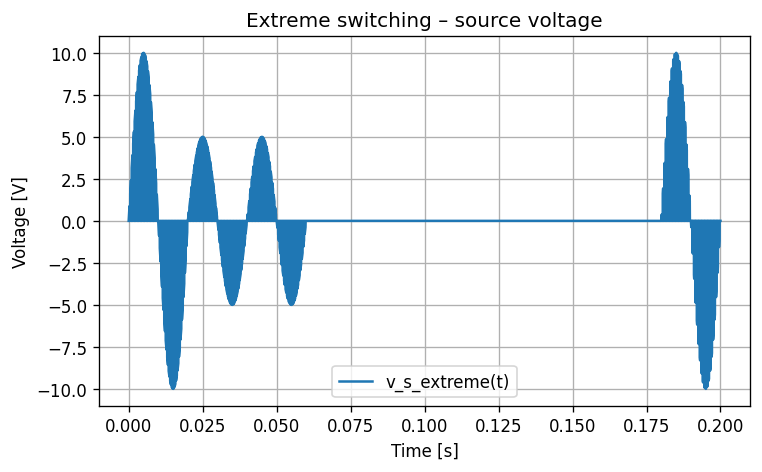

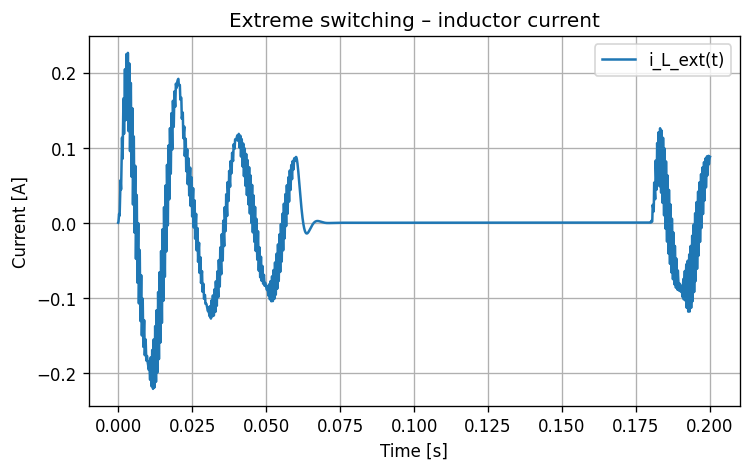

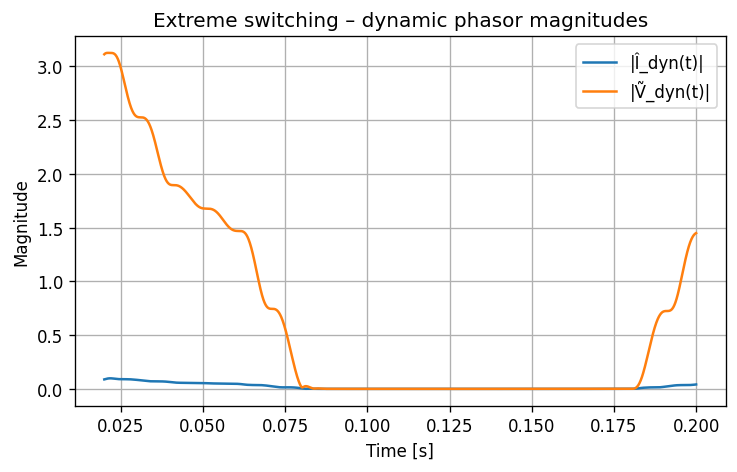

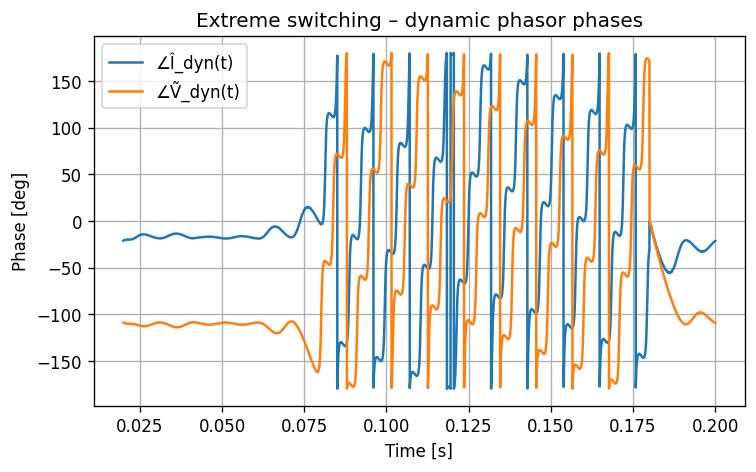

In [39]:
# ---- Time-domain waveforms ----
fig, ax = plt.subplots()
ax.plot(t_ext, v_s_ext, label="v_s_extreme(t)")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Voltage [V]")
ax.set_title("Extreme switching – source voltage")
ax.legend()
ax.grid(True)
plt.show()

fig, ax = plt.subplots()
ax.plot(t_ext, i_L_ext, label="i_L_ext(t)")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Current [A]")
ax.set_title("Extreme switching – inductor current")
ax.legend()
ax.grid(True)
plt.show()

# ---- Dynamic phasor (ignore initial NaNs) ----
valid_ext = ~np.isnan(I_mag_ext)

fig, ax = plt.subplots()
ax.plot(t_ext[valid_ext], I_mag_ext[valid_ext], label="|Î_dyn(t)|")
ax.plot(t_ext[valid_ext], V_mag_ext[valid_ext], label="|Ṽ_dyn(t)|")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Magnitude")
ax.set_title("Extreme switching – dynamic phasor magnitudes")
ax.legend()
ax.grid(True)
plt.show()

fig, ax = plt.subplots()
ax.plot(t_ext[valid_ext], I_phase_ext[valid_ext], label="∠Î_dyn(t)")
ax.plot(t_ext[valid_ext], V_phase_ext[valid_ext], label="∠Ṽ_dyn(t)")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Phase [deg]")
ax.set_title("Extreme switching – dynamic phasor phases")
ax.legend()
ax.grid(True)
plt.show()
# ============================================================